In [26]:
import pandas as pd 
from sodapy import Socrata
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

head_dir = '/Users/kairstenfay/Downloads/'

## Read in Fremont Bike Data

Pull in Seattle's [Fremont Bridge Bicycle Counter data](https://data.seattle.gov/Transportation/Fremont-Bridge-Hourly-Bicycle-Counts-by-Month-Octo/65db-xm6k) by making the following API call. 

In [32]:
client = Socrata("data.seattle.gov", None)  # Unathenticated client

# Results returned as JSON from API / converted to Python list of
# dictionaries by sodapy. Convert the list to a pandas DataFrame
df = pd.DataFrame.from_records(client.get("4xy5-26gy", limit=100000))

print(df.shape)
print("\n")
print(df.dtypes)
print(df.head())

(52536, 3)
date                 object
fremont_bridge_nb    object
fremont_bridge_sb    object
dtype: object
                      date fremont_bridge_nb fremont_bridge_sb
0  2015-02-24T02:00:00.000                 3                 3
1  2017-01-09T06:00:00.000                55                28
2  2012-12-02T14:00:00.000                25                16
3  2016-02-15T00:00:00.000                 3                 3
4  2015-12-18T21:00:00.000                 7                17


Convert data types appropriately.

In [ ]:
df['fremont_bridge_nb'] = df['fremont_bridge_nb'].astype('int')
df['fremont_bridge_sb'] = df['fremont_bridge_sb'].astype('int')
df['Total'] = df['fremont_bridge_nb'] + df['fremont_bridge_sb']

# Convert date/time
df['Date'] = df['date'].astype('datetime64[ns]')

# Parse specific time labels from the new column
df['Day'] = df['Date'].map(lambda x: x.day)
df['Month'] = df['Date'].map(lambda x: x.month)
df['Year'] = df['Date'].map(lambda x: x.year)
df['Julian'] = df['Date'].map(lambda x: x.timetuple().tm_yday)
df['Hour'] = df['Date'].map(lambda x: x.hour)
df['Weekday'] = df['Date'].map(lambda x: x.dayofweek)
df.head()

# Fremont Bridge Bicycle Traffic data

Goal: Tell a story through visualization of time series data.

In [ ]:
sns.set(style="darkgrid")

plt.subplots(figsize=(15,9))

ax = sns.scatterplot(y = df['Total'], x = df['Date'], marker="|")
ax.set_xlim(df.iloc[0]['Date'], df.iloc[len(df) - 1]['Date'])

(735653.0833333334, 735319.25)

## Read in Seattle Rain Data

In [3]:
read_from_file = False

if read_from_file:
    rain = pd.read_csv(head_dir + \
                      'Observed_Rain_Gauge_Readings_-_5_Min_Intervals_-_Oct_2002_to_May_2017.csv')
print(rain.shape)
print(rain.dtypes)

(26076096, 7)
record_number      int64
month             object
quality_code     float64
rainfall_in      float64
site              object
time              object
wateryear          int64
dtype: object


In [177]:
run_to_datetime = False

if run_to_datetime:
    rain['time'] = rain['time'].astype('datetime64[ns]')
    
rain.describe()

record_number             int64
month                    object
quality_code            float64
rainfall_in             float64
site                     object
time             datetime64[ns]
wateryear                 int64
dtype: object


,record_number,quality_code,rainfall_in,wateryear
count,2.607610e+07,886176.000000,2.607602e+07,2.607610e+07
mean,3.772943e+07,13.638785,3.583162e-04,2.009799e+03
std,2.095945e+07,27.233405,2.306342e-03,4.213769e+00
min,2.743487e+06,1.000000,0.000000e+00,2.003000e+03
25%,2.023646e+07,7.000000,0.000000e+00,2.006000e+03
50%,3.772943e+07,7.000000,0.000000e+00,2.010000e+03
75%,5.522240e+07,7.000000,0.000000e+00,2.013000e+03
max,7.271537e+07,130.000000,3.100000e-01,2.017000e+03


In [ ]:
# Scatter the Seattle Rain Catch data 
ax = sns.scatterplot(y = rain['rainfall_in'], x = rain['time'])


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/Users/kairstenfay/miniconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/Users/kairstenfay/miniconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/kairstenfay/miniconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/kairstenfay/miniconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/kairstenfay/miniconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Users/kairstenfay/miniconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.r

Text(0.5, 57.5, 'Julian Calendar Day (1 through 365)')

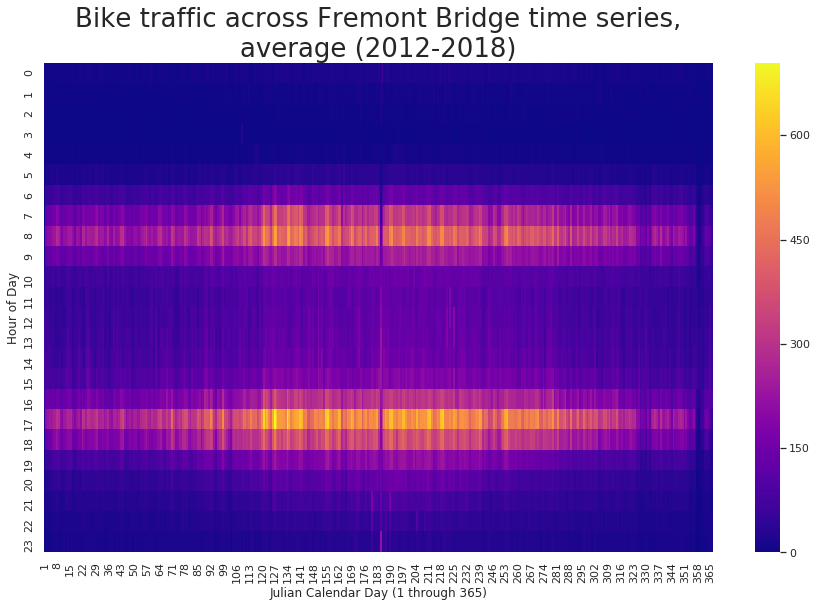

In [151]:
agg = df.groupby(by=['Day', 'Month', 'Year', 'Hour', 'Julian'], as_index=False).mean()
agg = agg.pivot_table("total", "Hour", "Julian")
agg.head()
plt.subplots(figsize=(15,9))
ax = sns.heatmap(agg, cmap='plasma')
ax.set_title('Bike traffic across Fremont Bridge time series,\naverage (2012-2018)',
            fontsize=26)
ax.set_ylabel('Hour of Day')
ax.set_xlabel('Julian Calendar Day (1 through 365)')

Text(0.5, 57.5, 'Year & Month')

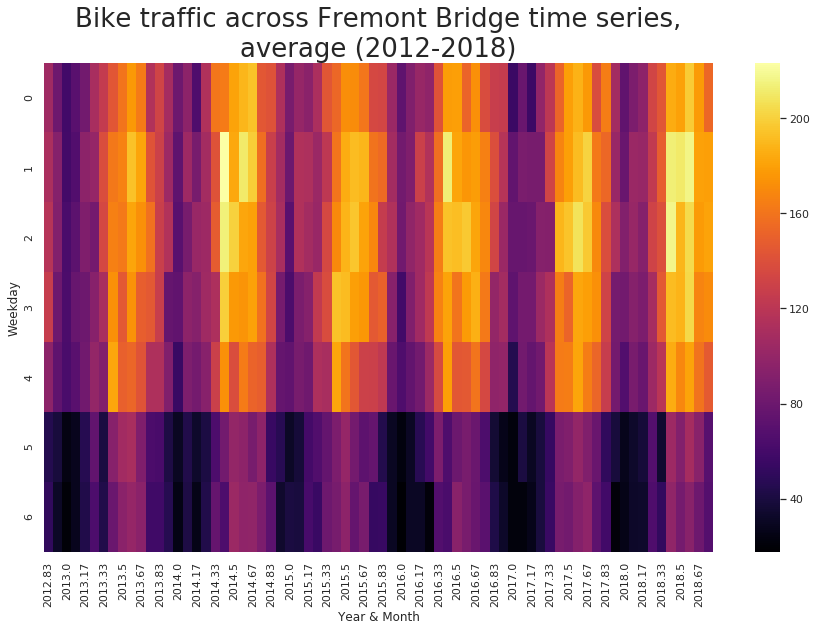

In [161]:
df['YearMonth'] = np.around(df['Year'] + df['Month']/12, 2)
agg = df.groupby(by=['Weekday', 'YearMonth'], as_index=False).mean()
agg = agg.pivot_table("total", "Weekday", "YearMonth")
agg.head()
plt.subplots(figsize=(15,9))
ax = sns.heatmap(agg, cmap='inferno')
ax.set_title('Bike traffic across Fremont Bridge time series,\naverage (2012-2018)',
            fontsize=26)
ax.set_ylabel('Weekday')
ax.set_xlabel('Year & Month')

Text(0.5, 57.5, 'Year & Month')

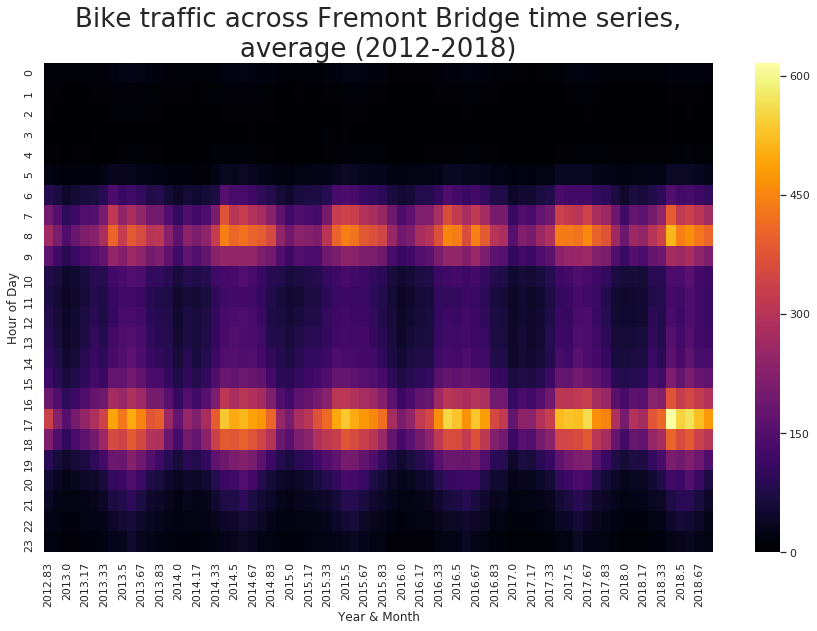

In [162]:
df['YearMonth'] = np.around(df['Year'] + df['Month']/12, 2)
agg = df.groupby(by=['Hour', 'YearMonth'], as_index=False).mean()
agg = agg.pivot_table("total", "Hour", "YearMonth")
agg.head()
plt.subplots(figsize=(15,9))
ax = sns.heatmap(agg, cmap='inferno')
ax.set_title('Bike traffic across Fremont Bridge time series,\naverage (2012-2018)',
            fontsize=26)
ax.set_ylabel('Hour of Day')
ax.set_xlabel('Year & Month')

Text(0.5, 57.5, 'Year & Month')

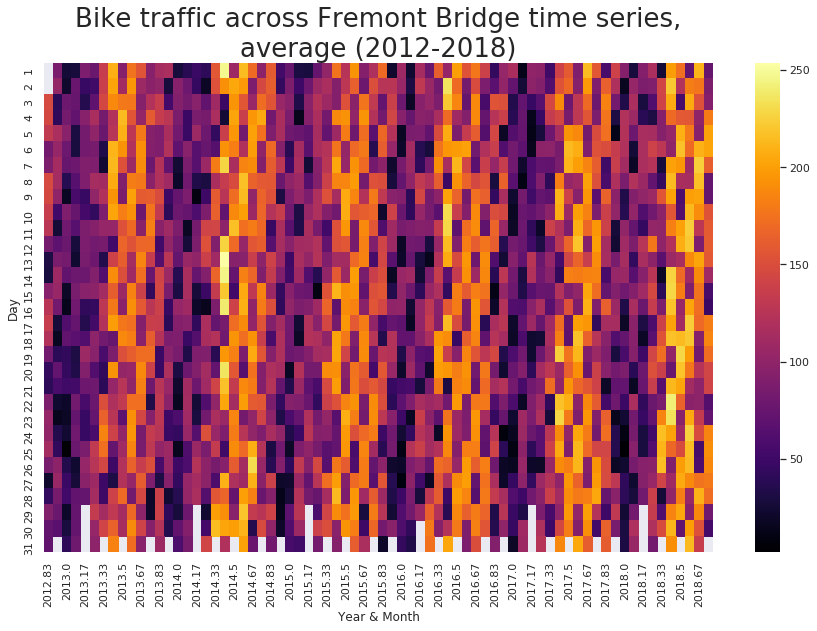

In [163]:
df['YearMonth'] = np.around(df['Year'] + df['Month']/12, 2)
agg = df.groupby(by=['Day', 'YearMonth'], as_index=False).mean()
agg = agg.pivot_table("total", "Day", "YearMonth")
agg.head()
plt.subplots(figsize=(15,9))
ax = sns.heatmap(agg, cmap='inferno')
ax.set_title('Bike traffic across Fremont Bridge time series,\naverage (2012-2018)',
            fontsize=26)
ax.set_ylabel('Day')
ax.set_xlabel('Year & Month')

## Beautiful mistakes

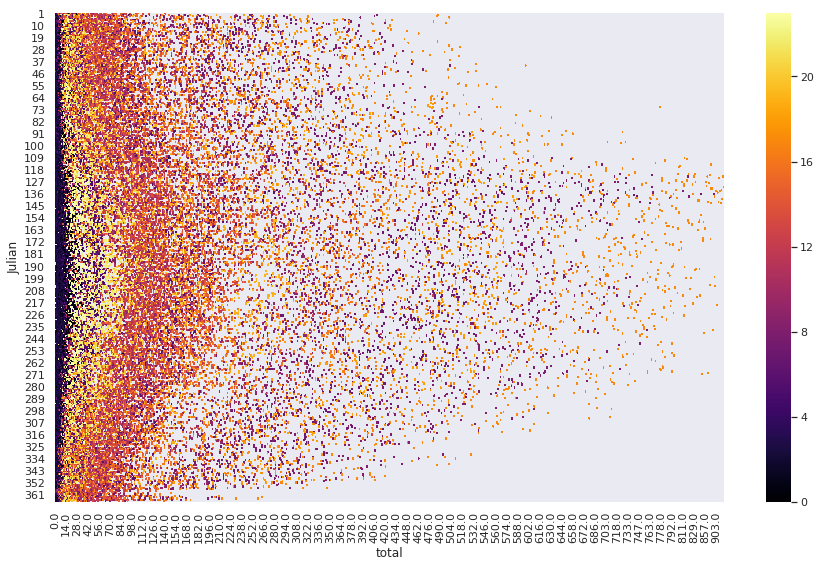

In [164]:
agg = df.groupby(by=['Day', 'Month', 'Year', 'Hour', 'Julian'], as_index=False).mean()
agg = agg.pivot_table("Hour", "Julian", "total")
agg.head()
plt.subplots(figsize=(15,9))
ax = sns.heatmap(agg, cmap='inferno')

In [65]:
df.head()

,Date,Fremont Bridge East Sidewalk,Fremont Bridge West Sidewalk,total
0,2012-10-03 00:00:00,9.0,4.0,13.0
1,2012-10-03 01:00:00,6.0,4.0,10.0
2,2012-10-03 02:00:00,1.0,1.0,2.0
3,2012-10-03 03:00:00,3.0,2.0,5.0
4,2012-10-03 04:00:00,1.0,6.0,7.0


10

In [44]:
df.iloc[0]['Date']

Timestamp('2012-10-03 00:00:00')